# Akuna Project

## Alessandro Bottoni, Leila Cielok, Silvia Guidi, Alessandro Macchi, Francesco Sebastiano Memmola, Paolo Minini, Simona Wang

## Libraries

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster import hierarchy
from scipy import stats
import logging, sys
logging.disable(sys.maxsize)
from pca import pca
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

## Import Data

In [95]:
akuna_data = pd.read_csv("data/akuna_data.csv",)

## Segmentation

In [96]:
ita_indices = range(14, 23)
eng_indices = range(67, 85)

clean_names = [
    "Boot weight", "Softness of material", "Foot Fit", "Durability", 
    "Brand Reputation", "Ball control", "Ease of fit", "Color options", "Quality Preference"
]
akuna_segmentation_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_segmentation_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_segmentation_data.dropna(inplace=True)


print(akuna_segmentation_data.head())

   Boot weight  Softness of material  Foot Fit  Durability  Brand Reputation  \
1          2.0                   2.0       5.0         4.0               5.0   
2          3.0                   3.0       5.0         5.0               2.0   
3          2.0                   4.0       5.0         5.0               4.0   
5          2.0                   3.0       5.0         4.0               3.0   
6          3.0                   1.0       5.0         5.0               2.0   

   Ball control  Ease of fit  Color options  Quality Preference  
1           5.0          5.0            2.0                 5.0  
2           2.0          2.0            1.0                 2.0  
3           4.0          2.0            1.0                 4.0  
5           5.0          1.0            1.0                 5.0  
6           3.0          5.0            1.0                 4.0  


For each segmentation variable we asked the respondents to evaluate from 1 to 5 how important each attribute is based on their own preference (where 1=not important at all, 5= very important)

Let's visualize the main descriptive stats of our segmentation variables

In [97]:
akuna_segmentation_data.describe().style.format("{:.1f}")

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
mean,3.0,3.9,4.5,4.1,2.4,3.9,2.4,1.9,3.8
std,1.0,1.0,0.7,0.9,1.2,1.2,1.3,1.1,1.1
min,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.0,3.0,4.0,4.0,1.0,3.0,1.0,1.0,3.0
50%,3.0,4.0,5.0,4.0,2.0,4.0,2.0,2.0,4.0
75%,4.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


### Clustering

#### Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.13835851547348088
For n_clusters = 3 The average silhouette_score is : 0.09385088080420913
For n_clusters = 4 The average silhouette_score is : 0.1024171323031649
For n_clusters = 5 The average silhouette_score is : 0.10565213900431537


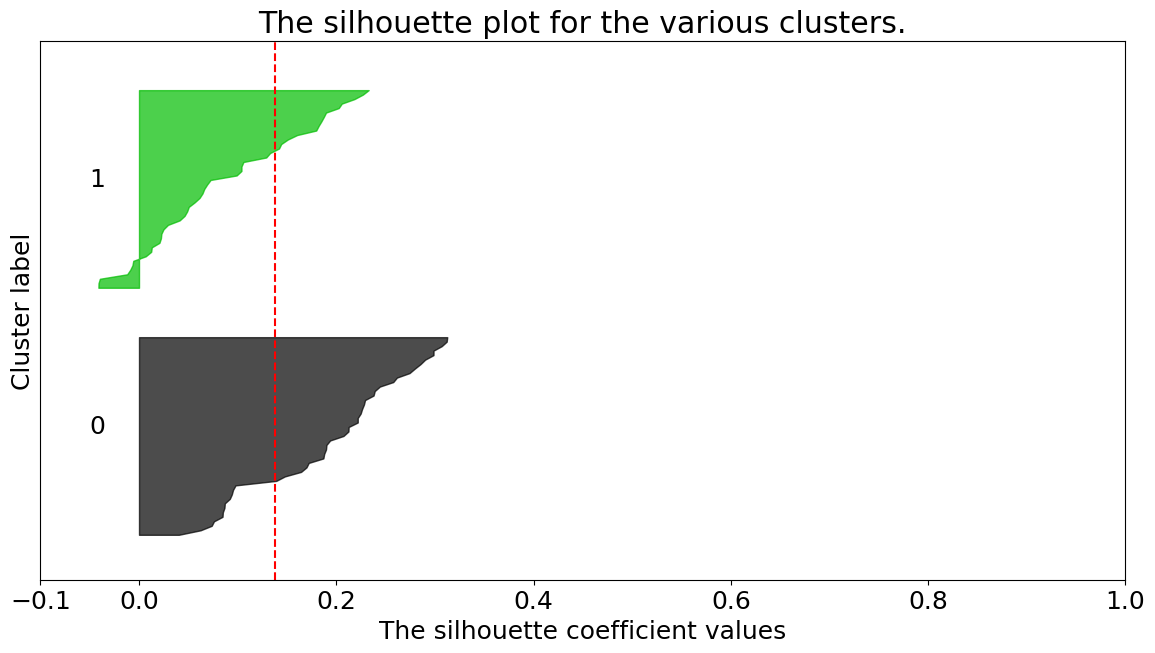

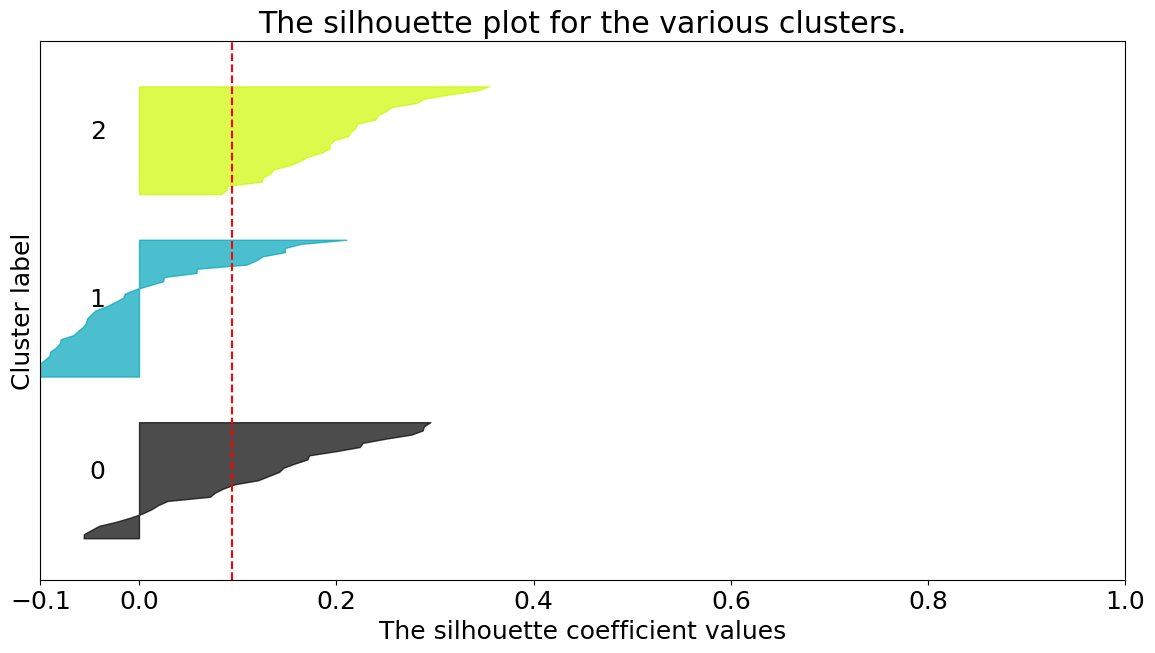

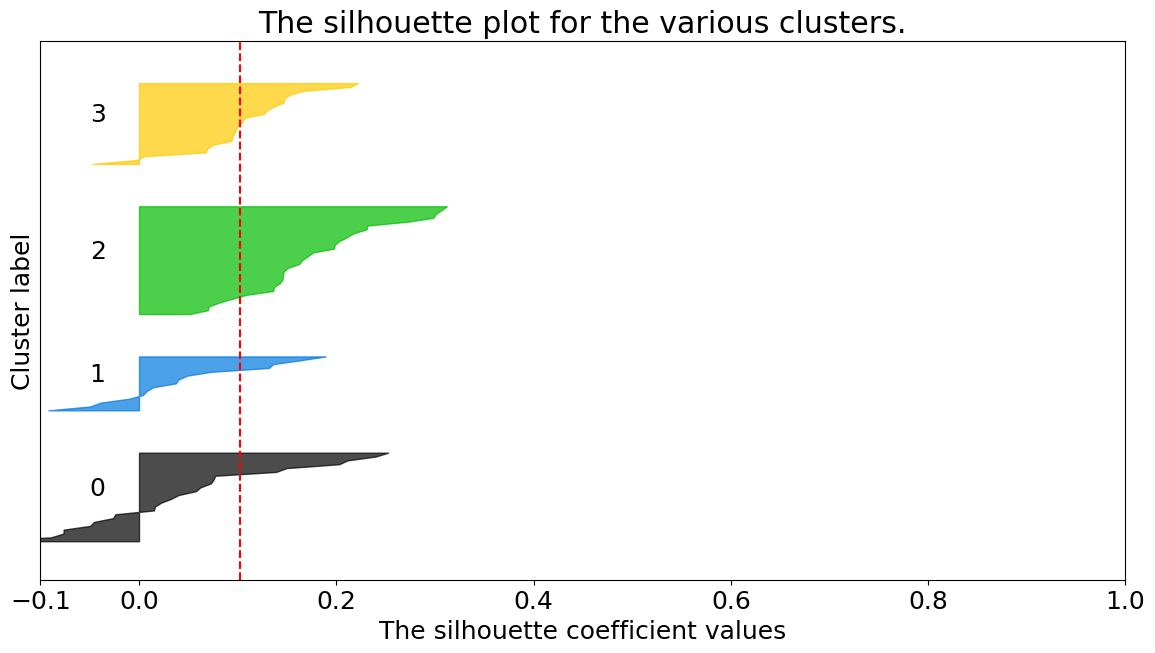

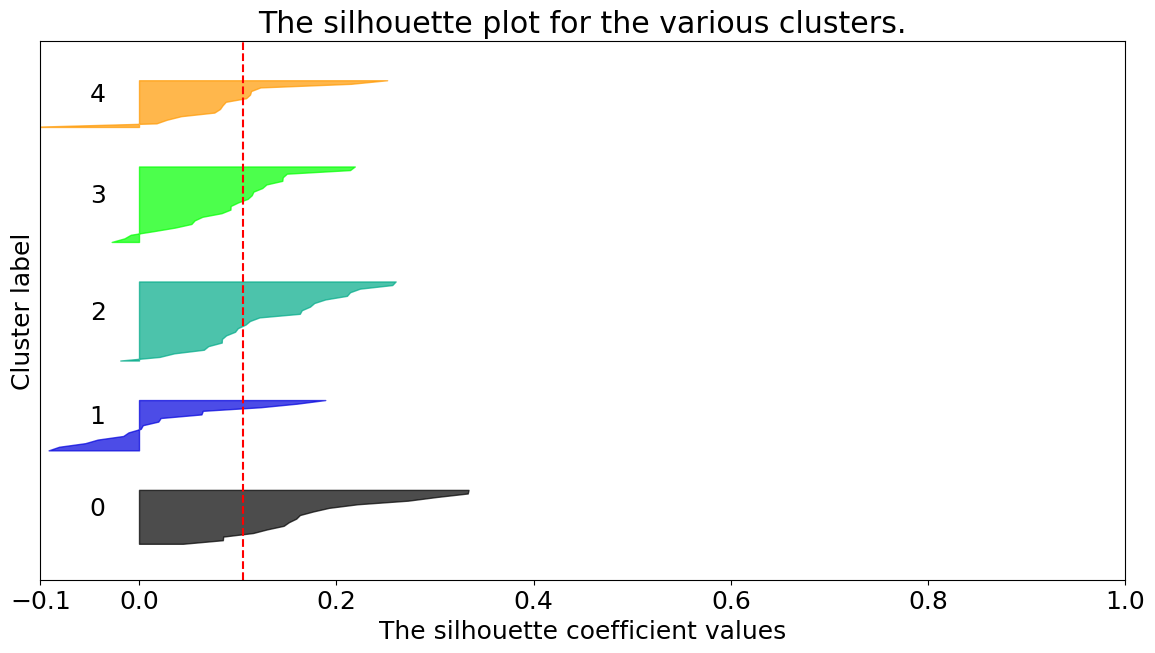

In [98]:
X = akuna_segmentation_data.to_numpy()
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    # Silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Silhouette plots show weak structure: most coefficients are close to 0 (some negative), so clusters overlap heavily.
Average silhouette decreases as k increases; k=2 appears relatively best but still indicates only coarse segmentation.

#### Elbow method

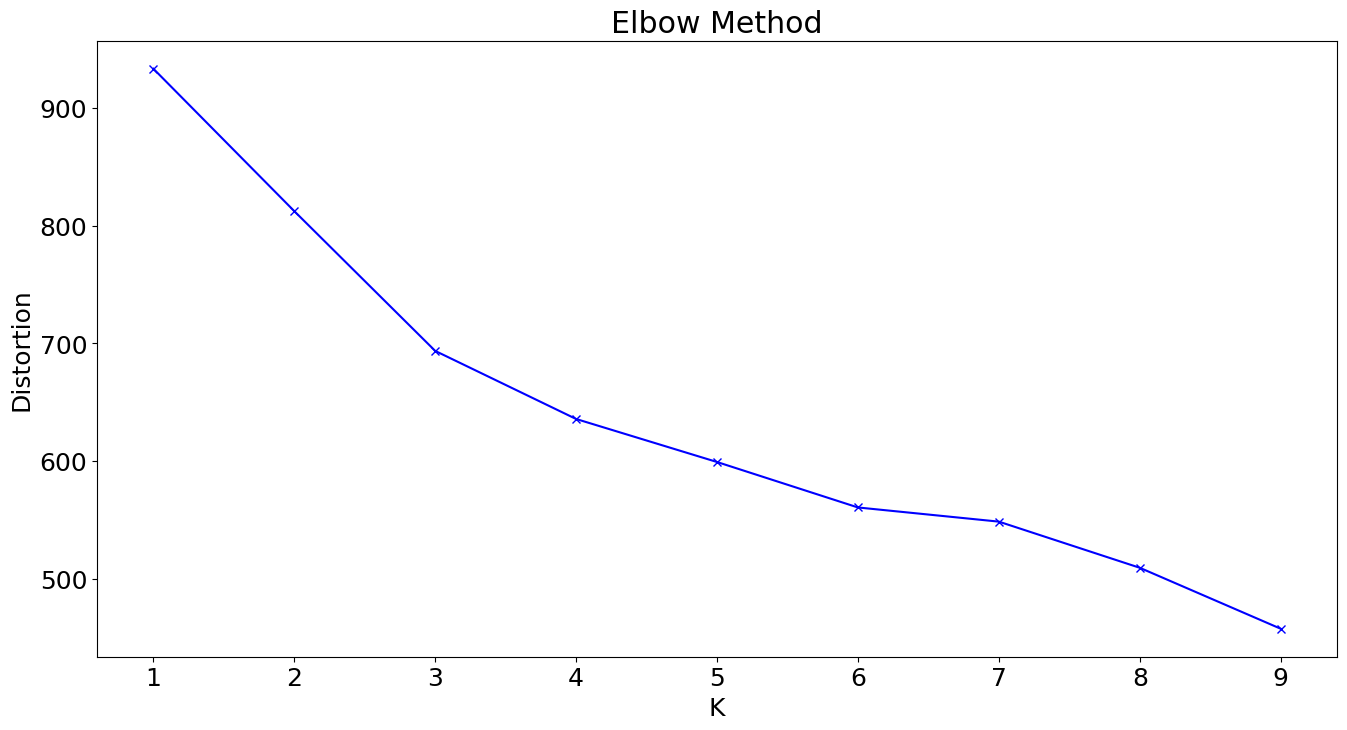

In [99]:
distortions = [KMeans(n_clusters=K).fit(akuna_segmentation_data).inertia_ for K in range(1,10)]
    
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('K'); plt.ylabel('Distortion'); plt.title('Elbow Method');

The elbow appears to be at k=3, even though it's not clearly detectable. Still, we will use this number of cluster. 

#### 3 Segments solution using K-Means

In [100]:
# Perform clustering with K=n, relabel cluster to [1,2,3], add cluster labels back to dataset and show first 8 rows
akuna_segmentation_data["SegmentKM"] = KMeans(n_clusters=3,random_state=42).fit(akuna_segmentation_data).labels_
akuna_segmentation_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"] + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3


In [101]:
# Segment sizes 
akuna_segmentation_data_Sizes = pd.DataFrame(akuna_segmentation_data.groupby("SegmentKM").size(),columns=["Size"]).T
akuna_segmentation_data_Sizes.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_Sizes.loc["%"] = akuna_segmentation_data_Sizes.iloc[0].div(akuna_segmentation_data_Sizes.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_Sizes

SegmentKM,Population,1,2,3
Size,90,20,45,25
%,100,22,50,27


#### Segments description

This is the significance of means differences between each segment and the rest of the population.

In [102]:
akuna_segmentation_data_Means = akuna_segmentation_data.groupby("SegmentKM").mean().T
akuna_segmentation_data_Means.insert(0,"Population",akuna_segmentation_data.drop(columns="SegmentKM").mean())
akuna_segmentation_data_Means.round(2)

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


In [103]:
X = akuna_segmentation_data.copy()

def style_cols(col):
    if col.name == "Population": return ["background-color: white"]*len(col)
    
    segment = X[X.SegmentKM == col.name]
    rest_pop = X[X.SegmentKM != col.name]
    
    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name],equal_var=False)
        #_,p_value,_ = st.ttest_ind(segment[var_name],rest_pop[var_name],usevar="unequal")    
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else: color = "background-color: white"
        colors.append(color)
    return colors

akuna_segmentation_data_Means.style.apply(style_cols).format("{:.2f}")

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


##### **Particular attention** to Quality Preference!

Given the nature of the question posed for this variable we give particular attention to the results within clusters of this attribute. Cluster 1 and Cluster 2 show significant differences highlighting the fact that (at least) two groups of customers show different preferences when it comes to the quality/price trade-off.

Cell colors indicate mean differences vs population: strong colors p<0.05, lighter colors 0.05<=p<0.10; green/red denote higher/lower importance.
* Segment 1: Performance-oriented profile, with significantly higher importance placed on ball control, foot fit, durability, and overall quality.
* Segment 2: Low-engagement profile, consistently assigning lower importance to brand, ease of fit, color options, and quality-related attributes.
* Segment 3: Comfort- and fit-focused profile, emphasizing ease of fit and material softness, with less emphasis on brand reputation.

#### Segmentation space using PCA (with pca package)

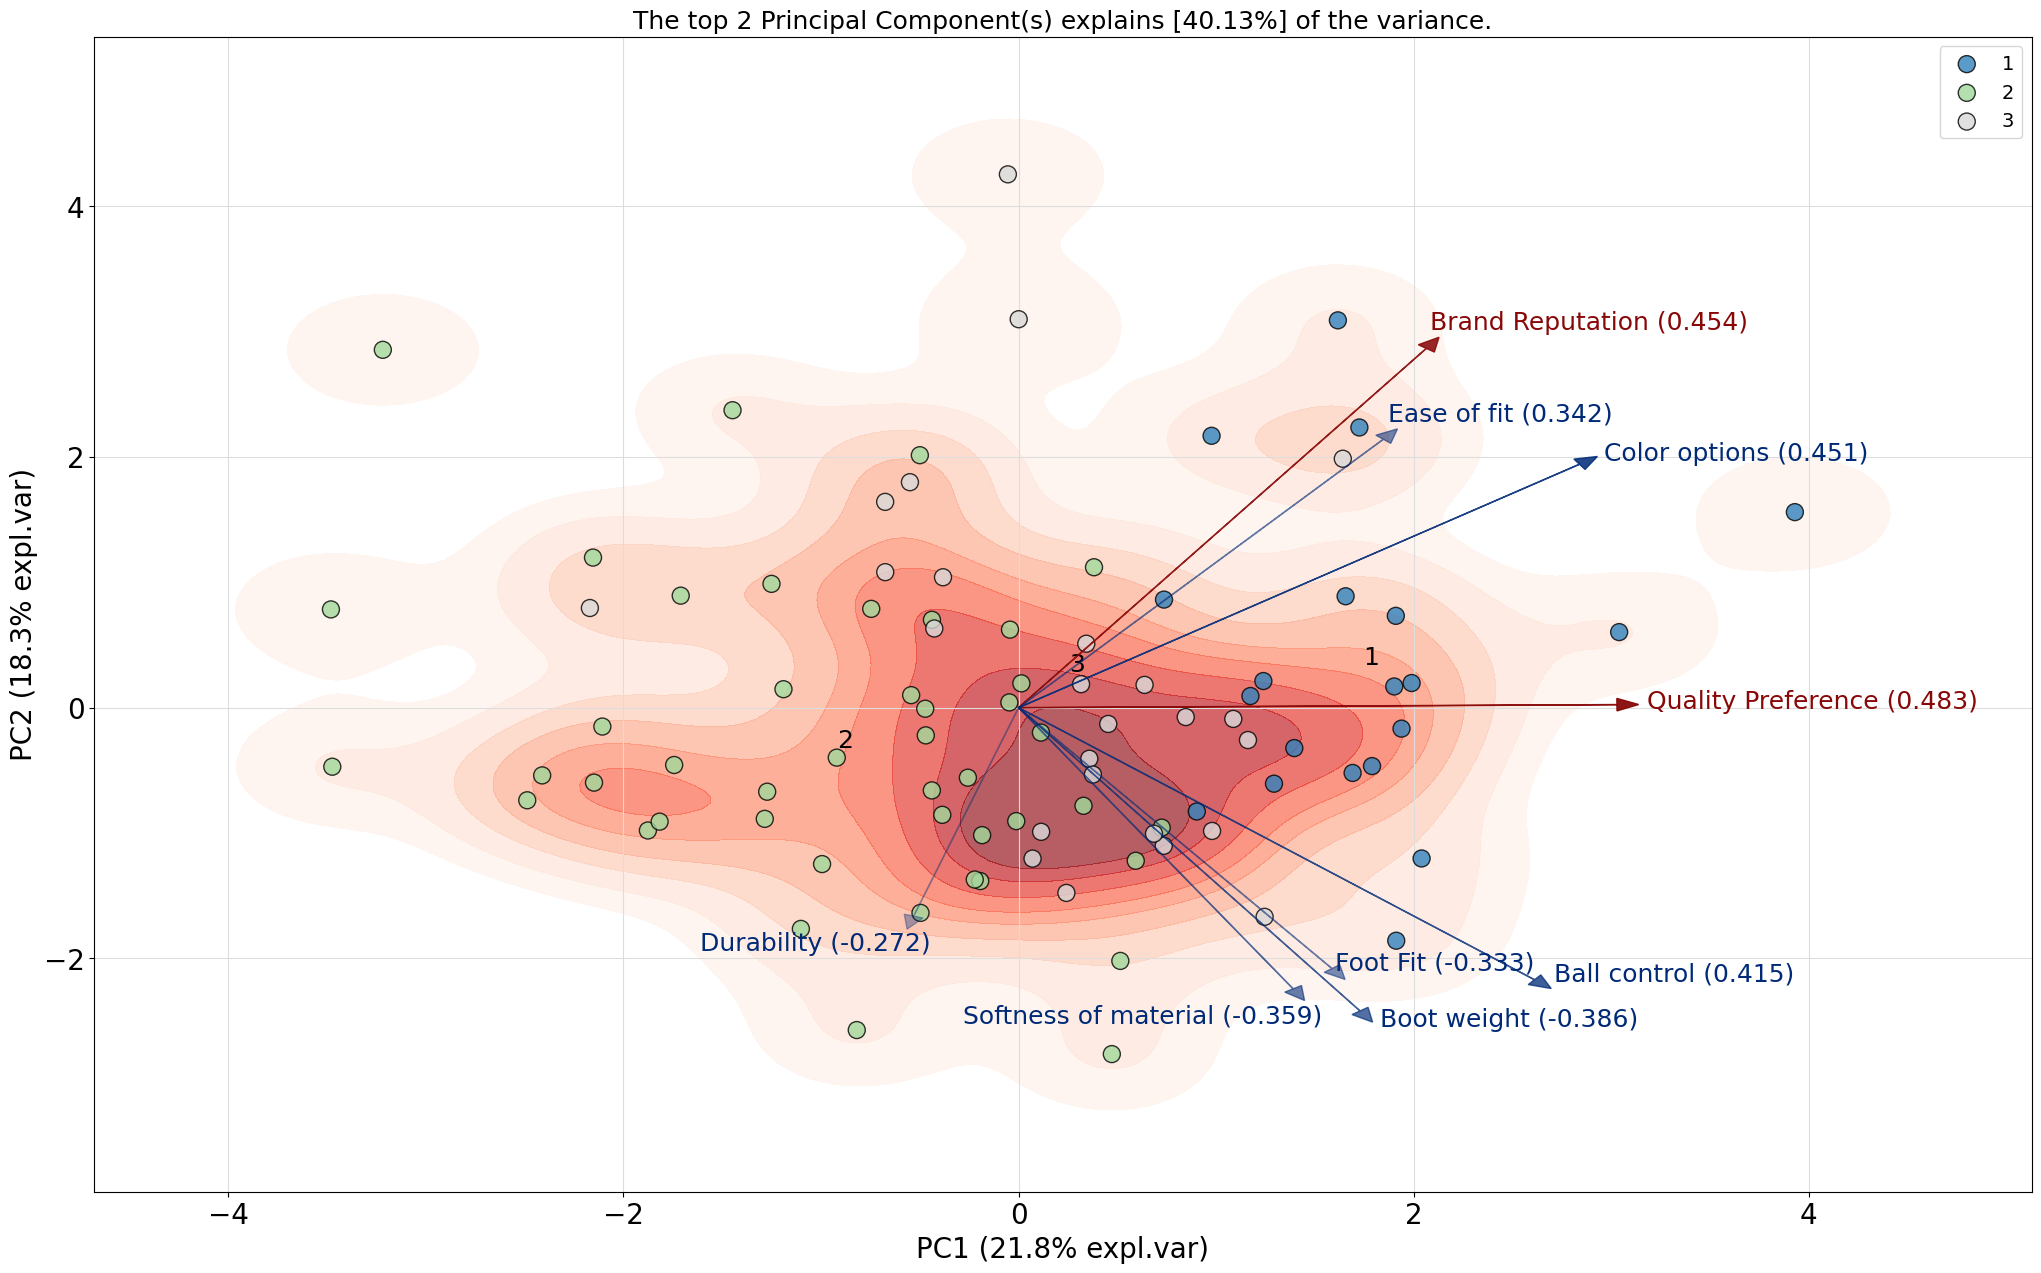

In [104]:
model = pca(n_components=2,normalize=True)
features = akuna_segmentation_data.drop(columns="SegmentKM")
segments = akuna_segmentation_data.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True);

PCA biplot (PC1 on X, PC2 on Y): the first two PCs explain ~40% of total variance, indicating moderate dimensionality reduction.
* PC1 (left→right) summarizes Quality Preference, Ball control and Color options.
* PC2 (bottom→top) captures most of the variables regarding the manufacturing of the shoes.

Clusters overlap in the PC1–PC2 plane, consistent with weak separation (low silhouette) and soft preference profiles.

#### 3-Segments solution using Hierarchical Clustering

In [105]:
hc = AgglomerativeClustering(n_clusters = 3,linkage="ward")
hc.fit(akuna_segmentation_data)

akuna_segmentation_data["SegmentHC"] = hc.labels_ + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM,SegmentHC
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1,2
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2,3
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2,3
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2,3
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3,1
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2,3
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2,1
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3,1


Segments sizes

In [106]:
akuna_segmentation_data_SizesHC = pd.DataFrame(akuna_segmentation_data.groupby("SegmentHC").size(),columns=["Size"]).T
akuna_segmentation_data_SizesHC.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_SizesHC.loc["%"] = akuna_segmentation_data_SizesHC.iloc[0].div(akuna_segmentation_data_SizesHC.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_SizesHC

SegmentHC,Population,1,2,3
Size,90,31,19,40
%,100,34,21,44


Dendrogram (Ward method) using scipy package

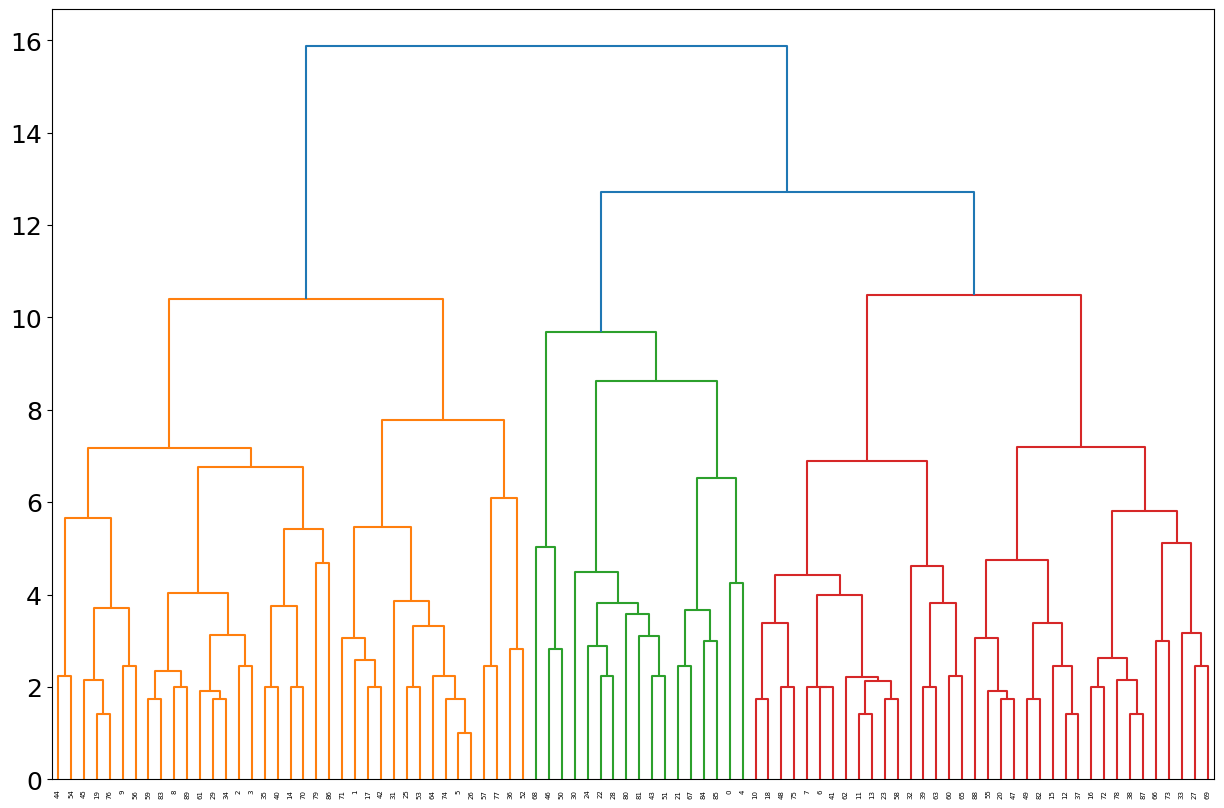

In [107]:
X = akuna_segmentation_data.drop(columns=["SegmentKM","SegmentHC"])

# Plot the hierarchical clustering as a dendrogram.
tree = hierarchy.linkage(X,'ward')
plt.figure(figsize=(15,10))
dn = hierarchy.dendrogram(tree)

### Descriptor Analysis

In [108]:
ita_indices = range(5, 14)
eng_indices = range(58, 67)

clean_names = [
    "Gender", "Occupation", "Region", "Age", 
    "Role", "Frequency", "Ground", "LastPurchase", "ShopPlace"
]
akuna_descriptor_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_descriptor_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_descriptor_data.dropna(inplace=True)

In [109]:
encoding_maps = {
    'Gender':{
    'Maschio': 'Male',
    "Male": "Male",
    'Femmina': 'Female',
    "Female":"Female",
    "Preferisco non specificarlo": "Prefer not to say",
    "Prefer not to say": "Prefer not to say"},
    
    'Occupation': {
    'Studente' : 'Student', 'Student' : 'Student',
    'Dipendente' : 'Employee', 'Employee' : 'Employee',
    'Libero professionista' : 'Freelance', 'Freelance' : 'Freelance',
    'Altro' : 'Other', 'Other' : 'Other'},

    'Role': {
    'Difensore' : 'Defender', 'Defender' : 'Defender',
    'Attaccante' : 'Striker', 'Striker' : 'Striker',
    'Portiere' : 'Keeper', 'Keeper' : 'Keeper',
    'Centrocampista' : 'Midfielder', 'Midfielder' : 'Midfielder'},

    'Ground':{
    'Sintetico' : 'Artificial turf ', 'Artificial turf ' : 'Artificial turf ',
    'Naturale' : "Grass", 'Grass' : "Grass",
    'Alterno queste due superfici' : 'Mixed'},

    'ShopPlace':{
    'recarti in negozio':0, 'Physical on-site shop':0,
    'andare online':1},

    'LastPurchase': {
    'Less than 80€': 1, 'Meno di 80€': 1,
    'Between 80€ and 100€': 2, 'Tra gli 80€ e i 100€': 2,
    'Between 100€ and 150€': 3, 'Tra i 100€ e i 150€': 3,
    'More than 150€': 4, 'Più di 150€': 4},

    'Frequency' :{
    'Less than three times ': 1, 'Meno di tre': 1,
    'Between three and ten times ': 2, 'Tra le tre e le dieci': 2, 
    'More than ten times ': 3, 'Più di dieci': 3}
}

# trasformation
for col, mapping in encoding_maps.items():
    if col in akuna_descriptor_data.columns:
        akuna_descriptor_data[col] = akuna_descriptor_data[col].map(mapping)

In [110]:
akuna_descriptor_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"]
print("DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)")
akuna_descriptor_data.head(10)

DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)


,Gender,Occupation,Region,Age,Role,Frequency,Ground,LastPurchase,ShopPlace,SegmentKM
1,Male,Student,Abroad,25.0,Defender,2,Artificial turf,1,0,1
2,Male,Employee,Puglia,30.0,Midfielder,1,Artificial turf,1,0,2
3,Male,Student,Abroad,29.0,Midfielder,1,Artificial turf,1,0,2
5,Male,Student,Puglia,24.0,Defender,1,Artificial turf,1,0,2
6,Male,Employee,Lombardia,30.0,Defender,1,Artificial turf,2,0,3
7,Male,Student,Lombardia,24.0,Striker,3,Artificial turf,1,0,2
9,Male,Student,Liguria,24.0,Defender,1,Artificial turf,2,0,2
13,Male,Student,Liguria,23.0,Midfielder,1,Artificial turf,2,0,3
16,Male,Student,Liguria,23.0,Midfielder,1,Artificial turf,2,0,2
17,Male,Employee,Liguria,23.0,Defender,1,NaN,2,0,3


#### Segment description

In [111]:
numeric_cols = ['Age', 'LastPurchase', 'ShopPlace'] 

# numeric means per segment
seg_num = akuna_descriptor_data.groupby("SegmentKM")[numeric_cols].mean().T
pop_num = akuna_descriptor_data[numeric_cols].mean()

# Gender quotas per segment
seg_gender = (
    pd.crosstab(akuna_descriptor_data["Gender"], akuna_descriptor_data["SegmentKM"], normalize='columns')
    .rename(index=lambda x: f"Gender={x}")
)

pop_gender = (
    akuna_descriptor_data["Gender"].value_counts(normalize=True)
    .reindex(["Male", "Female", "Prefer not to say"])
)
pop_gender.index = [f"Gender={x}" for x in pop_gender.index]

# Merge: rows as variables, columns as segments 
segments_summary = pd.concat([seg_gender, seg_num], axis=0)
akuna_descriptor_data_Summary = segments_summary.copy()
akuna_descriptor_data_Summary.insert(0, "Population", pd.concat([pop_gender, pop_num]))


In [112]:
def fmt_value(v, idx):
    if isinstance(idx, str) and idx.startswith("Gender="):
        return f"{v:.1%}" if pd.notna(v) else ""
    return f"{v:.1f}" if pd.notna(v) else ""

formatted = akuna_descriptor_data_Summary.copy()

for r in formatted.index:
    formatted.loc[r] = [
        fmt_value(v, r)
        for v in akuna_descriptor_data_Summary.loc[r].values
    ]

/var/folders/3z/l5jprv3j0l9b65t8h1km257w0000gn/T/ipykernel_89862/2602486342.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.4%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted.loc[r] = [
/var/folders/3z/l5jprv3j0l9b65t8h1km257w0000gn/T/ipykernel_89862/2602486342.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted.loc[r] = [
/var/folders/3z/l5jprv3j0l9b65t8h1km257w0000gn/T/ipykernel_89862/2602486342.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.2%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted.loc[r] = [
/var/folders

In [113]:
def style_cols(col, numeric_df):
    if str(col.name) == "Population":
        return ["background-color: white"] * len(col)

    seg = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] == col.name]
    rest = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] != col.name]

    colors = []
    for var in col.index:
        seg_value = numeric_df.loc[var, col.name]   # <-- NUMERICO

        if isinstance(var, str) and var.startswith("Gender="):
            cat = var.split("=", 1)[1]
            a = (seg["Gender"] == cat).sum()
            b = (seg["Gender"] != cat).sum()
            c = (rest["Gender"] == cat).sum()
            d = (rest["Gender"] != cat).sum()

            table = np.array([[a, b], [c, d]])
            _, p_value, _, _ = stats.chi2_contingency(table)

            rest_share = (rest["Gender"] == cat).mean()
        else:
            x = pd.to_numeric(seg[var], errors="coerce")
            y = pd.to_numeric(rest[var], errors="coerce")
            _, p_value = stats.ttest_ind(x, y, nan_policy='omit', equal_var=False)

            rest_share = y.mean()

        if p_value < 0.05:
            color = "background-color: #2ecc71; color: white" if seg_value > rest_share else "background-color: #e74c3c; color: white"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if seg_value > rest_share else "background-color: #f1807e"
        else:
            color = "background-color: white"

        colors.append(color)

    return colors

In [114]:
# Format as percentages for Gender
def fmt_value(v, idx):
    if isinstance(idx, str) and idx.startswith("Gender="):
        return f"{v:.1%}" if pd.notna(v) else ""
    return f"{v:.1f}" if pd.notna(v) else ""

styled_table = formatted.style.apply(style_cols, axis=0, numeric_df=akuna_descriptor_data_Summary)

styled_table


SegmentKM,Population,1,2,3
Gender=Female,4.4%,10.0%,2.2%,4.0%
Gender=Male,93.3%,90.0%,95.6%,92.0%
Gender=Prefer not to say,2.2%,0.0%,2.2%,4.0%
Age,24.5,23.2,25.3,24.3
LastPurchase,1.7,2.1,1.5,1.8
ShopPlace,0.0,0.1,0.0,0.0


Highlighted cells mark statistically significant differences versus the rest of the sample (green = higher, red = lower).
Overall, the sample is strongly male-skewed across all segments. 

Segment 1 shows a relatively higher female share, while Segment 2 is the most male-dominated; “Prefer not to say” remains marginal throughout. Age differences are modest, with Segment 2 slightly older on average.

Behavioral variables are more discriminating: Segment 1 exhibits a higher LastPurchase value (higher price range), whereas Segment 2 shows a significantly lower LastPurchase. ShopPlace is also dominated by a tendency towards physical on-site shop .

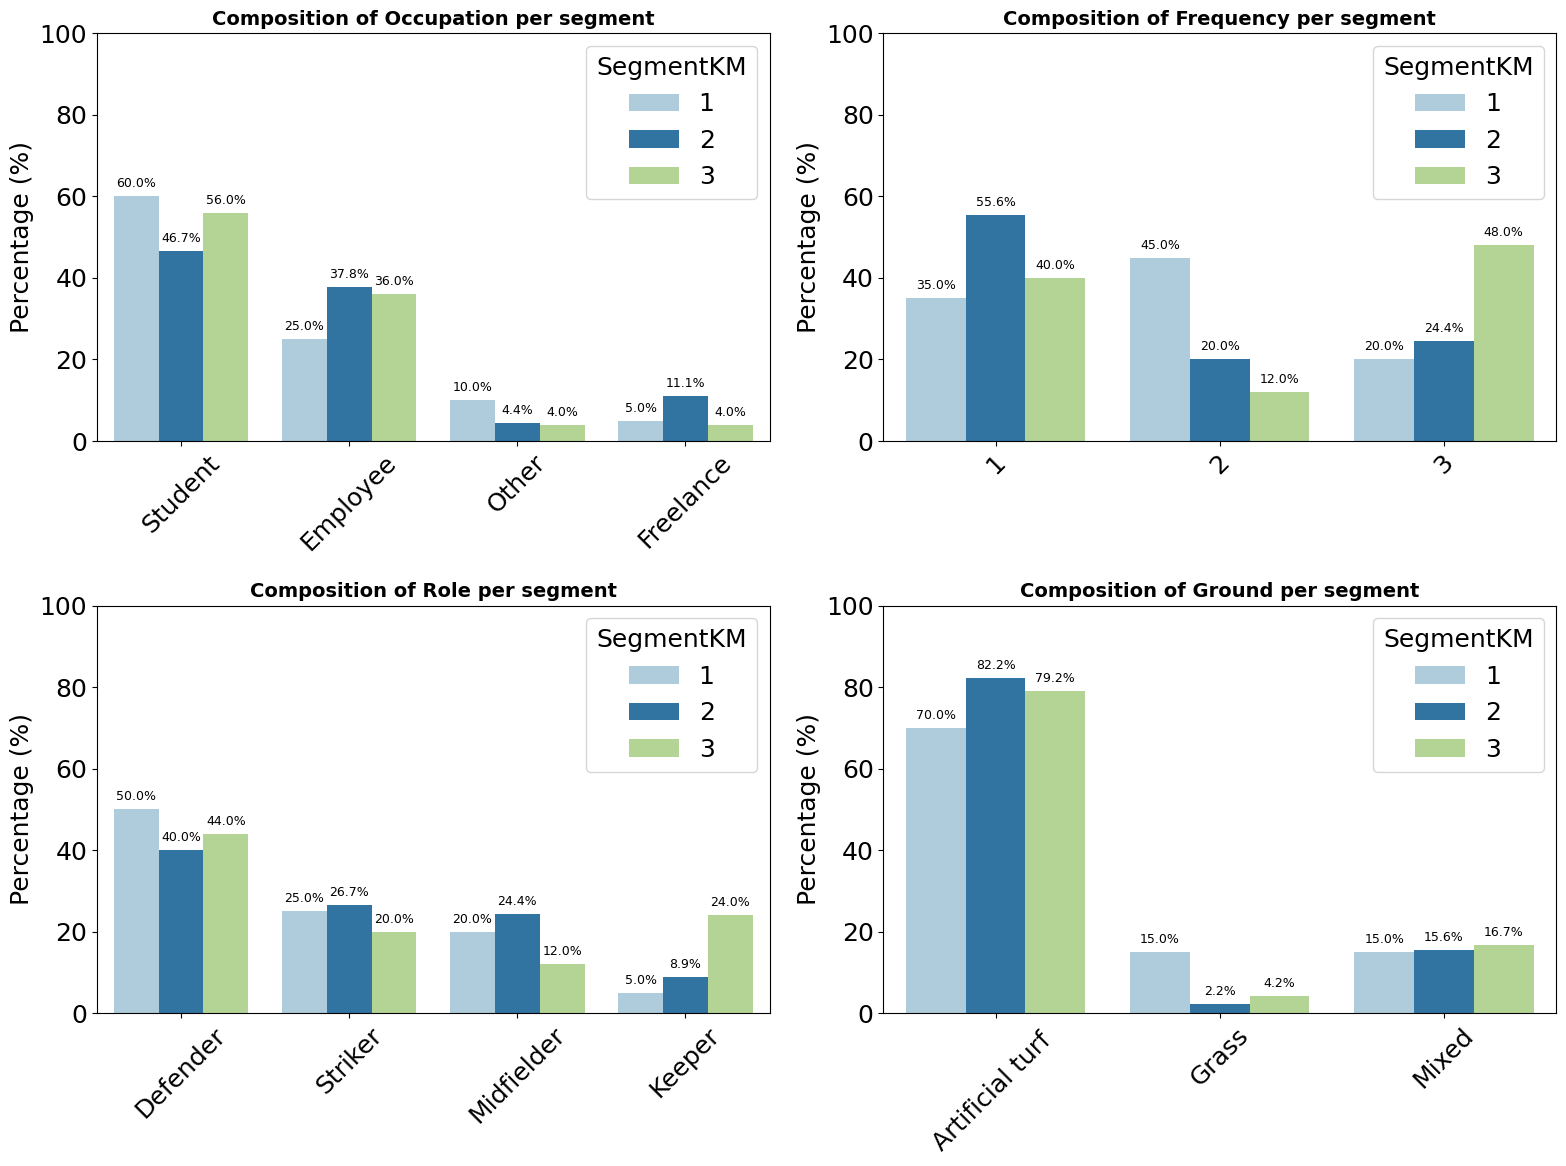

In [118]:
vars_to_plot = ['Occupation', 'Frequency', 'Role', 'Ground']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    prop_df = (akuna_descriptor_data.groupby('SegmentKM')[var]
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())
    
    prop_df['percentage'] *= 100

    sns.barplot(
        data=prop_df, 
        x=var, 
        y='percentage', 
        hue='SegmentKM', 
        ax=axes[i],
        palette='Paired'
    )
    
    axes[i].set_title(f'Composition of {var} per segment', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_ylim(0, 100) 
    axes[i].tick_params(axis='x', rotation=45)
    
    # Aggiunta etichette percentuali sopra le barre (opzionale)
    for p in axes[i].patches:
        if p.get_height() > 0:
            axes[i].annotate(f'{p.get_height():.1f}%', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points',
                             fontsize=9)

plt.tight_layout()
plt.show()

The categorical composition plots highlight clear structural differences across segments. In terms of occupation, all segments are dominated by students, though Segment 1 shows the highest student share, while Segments 2 and 3 display a relatively larger proportion of employees, indicating a more professionally oriented profile.

Differences are more pronounced for playing frequency. Segment 2 is characterized by a higher prevalence of low-frequency players (playing less than three times per month), whereas Segment 1 concentrates more medium-frequency players (three to ten times per month). Segment 3 stands out for the highest share of high-frequency players (more than ten times per month), indicating a more intensive engagement with the activity.

Regarding player role, defenders represent the most common role across all segments. However, Segment 3 shows a notably higher share of goalkeepers, while Segment 2 has a comparatively larger proportion of midfielders, indicating some degree of heterogeneity in playing profiles across clusters.

Finally, ground type is strongly skewed toward artificial turf in all segments, but Segment 2 exhibits the highest concentration, whereas Segment 1 and Segment 3 show a slightly more balanced mix with grass and mixed surfaces.

Overall, these distributions confirm that the segmentation primarily captures differences in behavioral intensity and usage context, rather than purely demographic characteristics.

### Classification model

Nei prossimi risultati il modello tiene il segmento 1 come baseline

In [ ]:
formula = "SegmentKM ~ C(Occupation) + C(Role) + C(Ground) + Age + LastPurchase + Frequency"
model_logit = smf.mnlogit(formula=formula, data=akuna_descriptor_data).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.874019
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              SegmentKM   No. Observations:                   89
Model:                        MNLogit   Df Residuals:                       65
Method:                           MLE   Df Model:                           22
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1545
Time:                        18:11:13   Log-Likelihood:                -77.788
converged:                       True   LL-Null:                       -92.001
Covariance Type:            nonrobust   LLR p-value:                    0.1620
               SegmentKM=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0668      3.206     -0.021      0.983      

Segment 2 significant results:
- LastPurchase (p = 0.023): The coefficient is -0.8182.  This means that as customers spend more on their shoes, they are significantly less likely to belong to Segment 2. This identifies Segment 2 as a "Value" or "Entry-level" segment.
- Ground [Grass] (p = 0.042): The coefficient is -3.4404. People who play on "Grass" are significantly less likely to be in Segment 2 compared to the reference ground type. Segment 2 might be your "Artificial Turf" or "Indoor" crowd.

Segment 3 comment: no significant variables, but Frequency (p = 0.100) is "trending." The positive coefficient (0.7517) suggests that higher-frequency players are leaning toward Segment 3, but you might need more data (a larger $N$) to prove this with statistical certainty.

Pseudo R-squared (0.1545): descriptors explain about 15% of why people fall into different K-Means clusters.
LLR p-value (0.1620): as a whole, the model isn't significantly better at predicting segments than just guessing the most common one. This is likely due to the small sample size ($N=89$) relative to the number of variables (22 degrees of freedom).

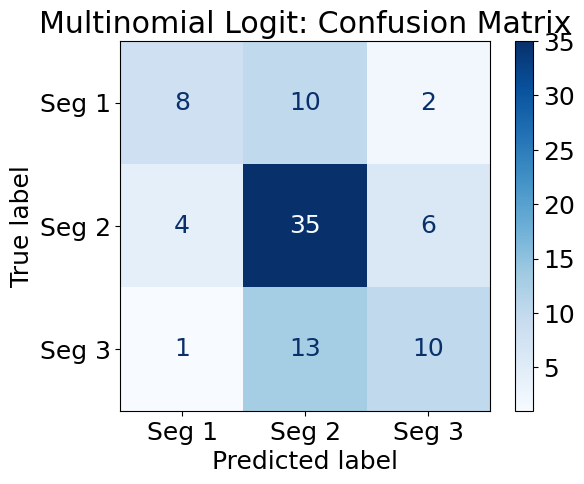

In [ ]:
pred_table = model_logit.pred_table()
disp = ConfusionMatrixDisplay(confusion_matrix=pred_table, 
                              display_labels=['Seg 1', 'Seg 2', 'Seg 3'])
disp.plot(cmap='Blues', values_format='.0f')
ax.grid(False)
plt.title("Multinomial Logit: Confusion Matrix")
plt.show()

The MNLogit model's performance highlights a moderate fit (Pseudo R-squared of 0.1545) but reveals significant classification overlap. The model effectively identifies the 'center' of Segment 2 but struggles with the boundaries of Segments 1 and 3, often misclassifying them into the majority predicted class. This suggests that the customer segments are characterized by complex, non-linear patterns that a standard linear logistic framework cannot fully resolve, leading to the observed 'leakage' between categories in the confusion matrix.

Classification using Random Forest Classifier (from sklearn package)

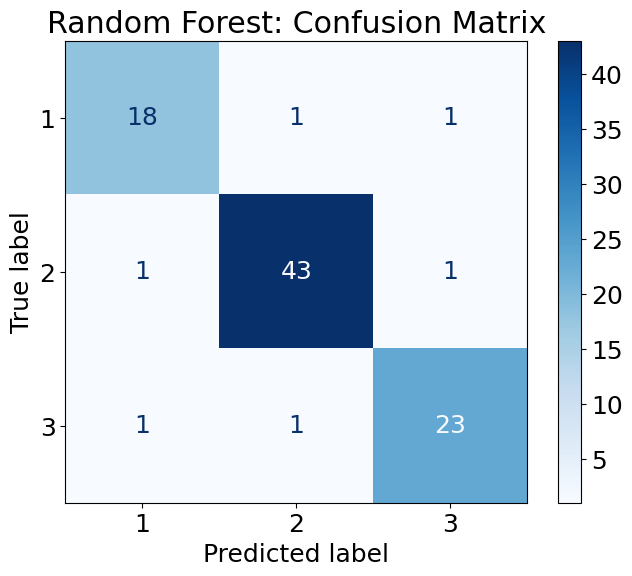

In [ ]:
cols_numeric = ['Age', 'LastPurchase', 'Frequency', 'ShopPlace']
cols_nominal = ['Gender', 'Occupation', 'Role', 'Ground']

X = pd.concat([
    akuna_descriptor_data[cols_numeric], 
    pd.get_dummies(akuna_descriptor_data[cols_nominal])
], axis=1)

y = akuna_descriptor_data.SegmentKM

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rf, X, y, cmap='Blues', ax=ax)
ax.grid(False) 
plt.title("Random Forest: Confusion Matrix")
plt.show()


The significant jump in classification accuracy from MNLogit to Random Forest indicates that the customer segments are not linearly separable. While the Logit model provides a useful baseline for identifying broad drivers, the Random Forest reveals that the true identity of each segment is hidden in high-dimensional interactions between the features. For predictive purposes or automated tagging of new customers, the Random Forest is the superior choice, as it nearly eliminates the misclassification issues found in the linear approach.

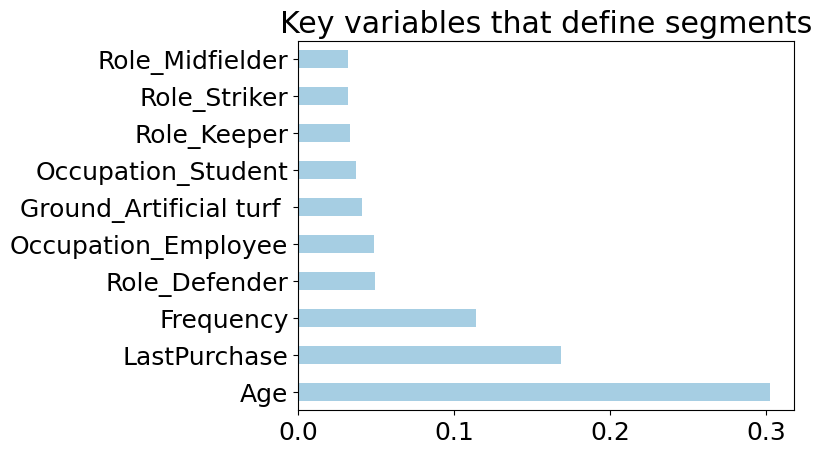

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(10).plot(kind='barh', cmap='Paired')
plt.title("Key variables that define segments")
plt.gca().grid(False) 
plt.show()

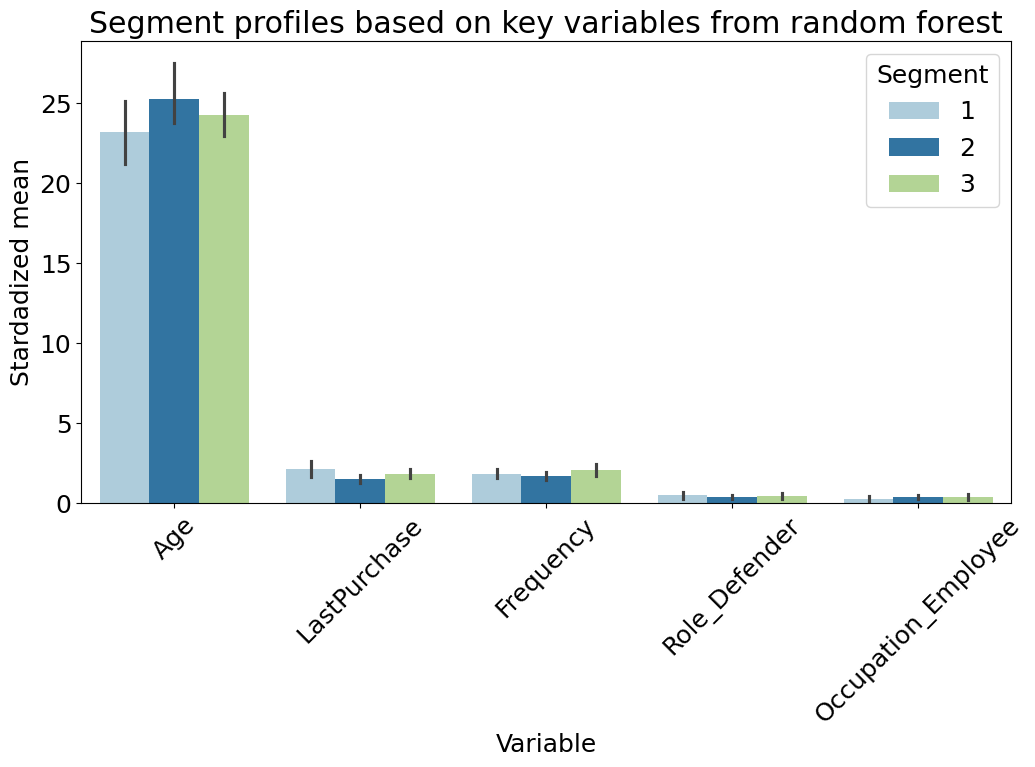

In [ ]:
top_features = importances.head(5).index.tolist()

df_plot = X[top_features].copy()
df_plot['Segment'] = y

df_melted = df_plot.melt(id_vars='Segment', var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Variable', y='Value', hue='Segment', palette='Paired')

plt.title("Segment profiles based on key variables from random forest")
plt.ylabel("Stardadized mean")
plt.xticks(rotation=45)
plt.grid(False) 
plt.show()

The profile chart explains the "logic" the Random Forest used to achieve that near-perfect confusion matrix:

- Segment 2 (The Mid-Career Group): This segment has the highest average Age. This likely explains why the Random Forest caught them so easily—it simply looked for the "older" players.

- Segment 1 (The Premium/Active Group): This group leads in LastPurchase value. They are your high-spenders who also show moderate frequency.

- Segment 3 (The High-Frequency Group): This segment stands out for having the highest Frequency of play, despite being slightly younger and spending less per purchase than Segment 1.

## Positioning

In [6]:
# 1. Load the dataset

df = akuna_data

print(f"Initial dataset shape: {df.shape}")
#df.head()

Initial dataset shape: (117, 110)


,Submission ID,Respondent ID,Submitted at,In che lingua preferisci svolgere questo sondaggio? - \nIn which language would you prefer to take the survey?,Hai mai acquistato delle scarpe da calcio?,Qual è il tuo genere?,Che lavoro fai?,Da dove provieni?,Quanti anni hai?,"Di solito, in che ruolo giochi?",...,Performance (10),Quality (5),At what price would the product seem so low in quality that you would no longer consider buying it?\n,At what price would the product start to seem like a very good deal?\n,At what price would you start to consider the product too expensive?\n,At what price would the product be so expensive that you would no longer consider buying it?\n,At what price would the product seem so low in quality that you would no longer consider buying it?\n (2),At what price would the product start to seem like a very good deal?\n (2),At what price would you start to consider the product too expensive?\n (2),At what price would the product be so expensive that you would no longer consider buying it?\n (2)
0,rjXaBGX,PdANzXP,2026-02-05 14:27:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,jaK66l4,yPlbJQp,2026-02-05 14:29:56,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,50.0,80.0,100.0,35.0,50.0,80.0,100.0
2,44ZJJyr,WOA6zzN,2026-02-05 14:31:37,Italiano,Sì,Maschio,Dipendente,Puglia,30.0,Centrocampista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZjxEEMz,zxKAYZq,2026-02-05 14:32:21,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,25.0,75.0,100.0,15.0,25.0,80.0,120.0
4,GxM998j,yPlbYE0,2026-02-05 14:32:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first step is to merge the english version of questions with the italian ones.

In [ ]:
# --- PHASE 1: MERGE ENGLISH -> ITALIAN ---

# Identify where the English section starts
english_start_phrase = "Have you ever bought a pair of football boots?"
split_index = -1
for i, col in enumerate(df.columns):
    if english_start_phrase in col:
        split_index = i
        break

if split_index == -1:
    raise ValueError("English section not found in CSV columns.")

# Define Italian and English column ranges
# (Adjust index 4 if your metadata columns differ)
italian_cols = df.columns[4:split_index]
english_cols = df.columns[split_index:]

# Create a working copy
df_compact = df.copy()

# Fill Italian NaNs with English responses
for col_it, col_en in zip(italian_cols, english_cols):
    df_compact[col_it] = df_compact[col_it].fillna(df_compact[col_en])

# Drop the now redundant English columns
df_compact = df_compact.drop(columns=english_cols)

print(f"Total columns after merging: {len(df_compact.columns)}")

Total columns after merging: 57


Afterwards, we remove all the people who don't give meaningful answers for the positioning section.

In [ ]:
# --- PHASE 2: APPLY FILTERS ---

# Filter 1: Remove respondents who have never bought football boots
col_shoes = "Hai mai acquistato delle scarpe da calcio?"
df_compact = df_compact[df_compact[col_shoes].astype(str).str.strip() != 'No']

# Filter 2: Remove respondents who have never heard of Akuna
col_akuna = 'Hai mai sentito parlare del brand "Akuna - Cinquestelle 1911"?'
df_compact = df_compact[df_compact[col_akuna].astype(str).str.strip() != 'No']

print(f"Rows remaining after filtering: {len(df_compact)}")

Rows remaining after filtering: 14


Then we rename columns to distinguish between different brands.

In [ ]:
# --- PHASE 3: PREPARE POSITIONING DATA ---

# Locate the brand awareness column to set the starting point
try:
    start_idx = df_compact.columns.get_loc(col_akuna)
except KeyError:
    for i, c in enumerate(df_compact.columns):
        if "Hai mai sentito parlare del brand" in c:
            start_idx = i
            break

# Locate the end of the section (where pricing questions begin)
end_idx = -1
for i, col in enumerate(df_compact.columns):
    if "A che prezzo" in col:
        end_idx = i
        break

# Extract the positioning subset
if end_idx != -1:
    df_pos = df_compact.iloc[:, start_idx:end_idx].copy()
else:
    df_pos = df_compact.iloc[:, start_idx:].copy()

# Define labels for renaming
brands = ["adidas", "akuna", "diadora", "mizuno", "pantofola_doro"]
attributes = ["craftsmanship", "durability", "popularity", "performance", "quality"]

new_pos_cols = ["know_akuna"]

# Generate standardized English column names
for brand in brands:
    for attr in attributes:
        new_pos_cols.append(f"{attr}_{brand}")

# Apply names if the count matches
if len(new_pos_cols) == len(df_pos.columns):
    df_pos.columns = new_pos_cols
    print("Columns renamed successfully.")
else:
    print(f"Error: Expected {len(new_pos_cols)} columns, found {len(df_pos.columns)}")

Columns renamed successfully.


In [ ]:
# --- PHASE 4: TRANSFORMATION FOR ANALYSIS ---

long_dfs = []

for brand in brands:
    # Select columns belonging to the current brand
    cols_to_keep = [f"{attr}_{brand}" for attr in attributes]
    
    # Create temp dataframe and strip the brand name from columns
    temp_df = df_pos[cols_to_keep].copy()
    temp_df.columns = attributes
    
    # Tag with brand name
    temp_df['brand'] = brand
    long_dfs.append(temp_df)

# Combine all into one master ratings dataframe
akuna_ratings = pd.concat(long_dfs, ignore_index=True)
akuna_ratings.head()

,craftsmanship,durability,popularity,performance,quality,brand
0,1.0,2.0,5.0,3.0,2.0,adidas
1,2.0,4.0,4.0,4.0,4.0,adidas
2,2.0,3.0,5.0,4.0,3.0,adidas
3,5.0,4.0,2.0,4.0,4.0,adidas
4,3.0,4.0,5.0,3.0,4.0,adidas


### Perceptual Data

The table below presents the mean scores for each brand across five key dimensions: Artigianalità (Craftsmanship), Durabilità (Durability), Popolarità (Popularity), Performance and Qualità (Quality).

In [ ]:
# --- PHASE 5: CALCULATE MEANS ---

# Group by brand and calculate the average for each attribute
akuna_perceptual = akuna_ratings.groupby("brand").mean(numeric_only=True)

print("Final Perceptual Map Coordinates (Brand Means):")
akuna_perceptual

Final Perceptual Map Coordinates (Brand Means):


,craftsmanship,durability,popularity,performance,quality
brand,,,,,
adidas,2.000000,3.428571,4.571429,3.714286,3.428571
akuna,4.857143,4.071429,2.142857,3.642857,4.357143
diadora,2.857143,3.214286,2.714286,3.142857,3.000000
mizuno,2.928571,3.357143,2.428571,3.214286,3.357143
pantofola_doro,4.357143,3.642857,2.714286,3.500000,3.857143


Akuna achieves near-perfect scores in Artigianalità (4.86) and commands the highest rating for Qualità (4.36). This is not merely a competitive advantage; it is a defining characteristic. The data suggests that for those who know the brand, Akuna is synonymous with the highest standards of boot-making.

Adidas represents the exact inverse of Akuna’s model. It dominates in Popolarità (4.57), benefiting from massive global visibility. However, its scores for Artigianalità (2.00) and Qualità (3.43) are significantly lower. This confirms a clear market trade-off: mass-market ubiquity often comes at the expense of perceived artisanal value.

Pantofola d'Oro is Akuna’s only true rival in the 'craftmanship' space. While Pantofola d'Oro performs admirably in Artigianalità (4.36) and Qualità (3.86), Akuna outperforms it across every single quality metric. Most notably, Akuna holds a significant lead in Durabilità (+0.43) and Qualità (+0.50).

Mizuno and Diadora occupy a "middle ground" with scores generally hovering around the 3.0 mark. They lack the specialized excellence of Akuna and the immense popularity of Adidas.

The exceptionally low Popolarità (2.14) of Akuna is not a failure but a reflection of its identity: ignoring the mass-market to focus on specific local markets.

### Positioning Map

In [ ]:
data = akuna_perceptual 

#print("Data loaded for PCA analysis.") eliminerei io 

Data loaded for PCA analysis.


From the table below, we conclude that the most important componentis the first one, which explains over 65% of the variance.

In [ ]:
# 1. Data Standardization
# (Equivalent to normalize=True in some R packages)
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# 2. Execute PCA
pca = PCA(n_components=2)
results = pca.fit_transform(data_std)

# Create a DataFrame with Brand Coordinates (Scores)
coord = pd.DataFrame(results, columns=['PC1', 'PC2'], index=data.index)

# Create a DataFrame with Attribute Vectors (Loadings)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data.columns)

print("PCA analysis complete.")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

PCA analysis complete.
Explained Variance Ratio: [0.65865357 0.32691972]


Finally we get to the most interesting part of this analysis: the positioning map.

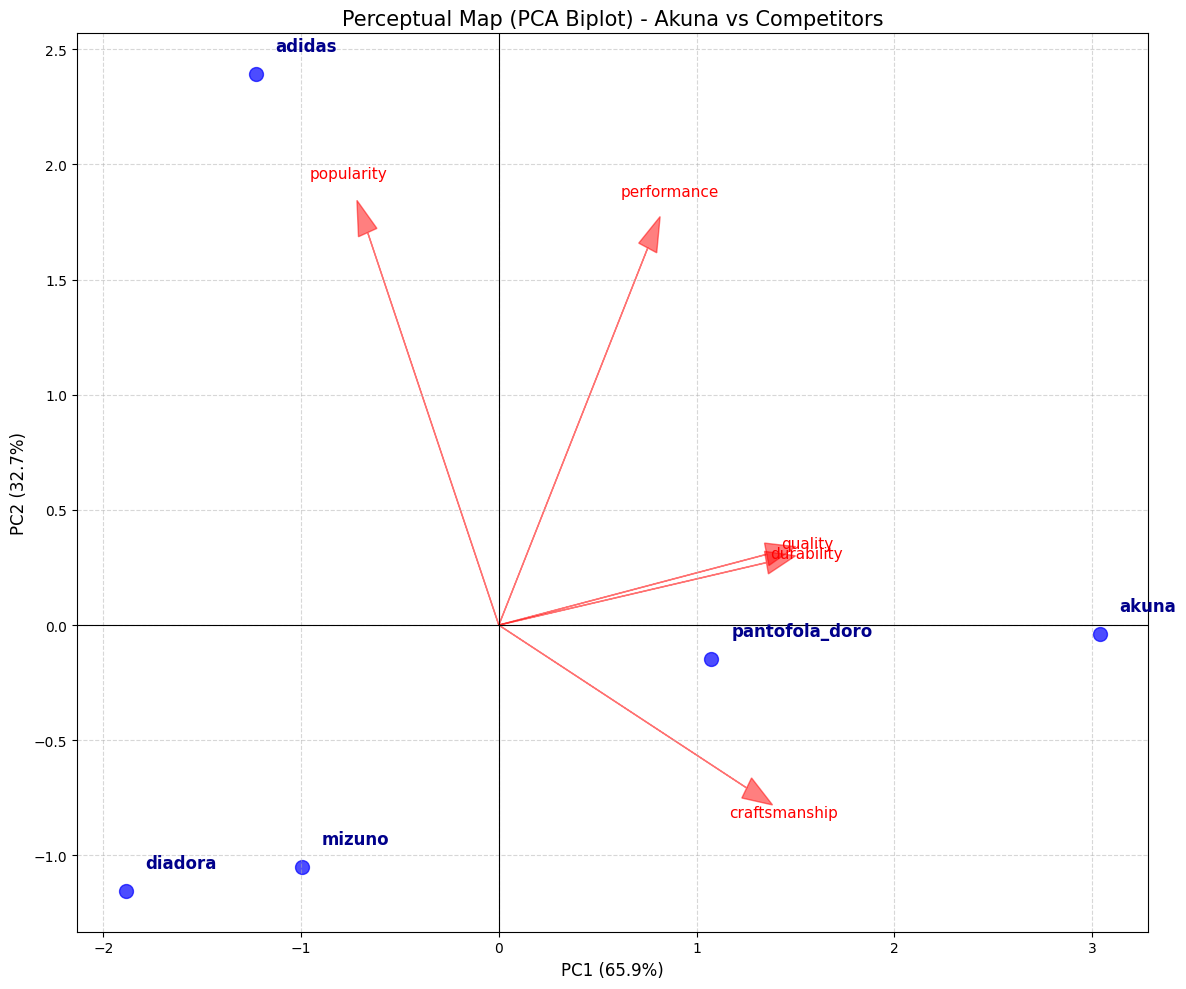

In [ ]:
# 3. Create the Biplot
plt.figure(figsize=(12, 10))
ax = plt.gca()

# --- Draw BRANDS (Blue Points) ---
# Scatter plot of coordinates
ax.scatter(coord['PC1'], coord['PC2'], c='blue', s=100, alpha=0.7, label='Brands')

# Add labels for the brands
for i, txt in enumerate(coord.index):
    # Offset the text slightly so it doesn't overlap the dot
    ax.text(coord.iloc[i, 0] + 0.1, coord.iloc[i, 1] + 0.1, txt, 
            fontsize=12, weight='bold', color='darkblue')

# --- Draw ATTRIBUTES (Red Arrows) ---
# Scale arrows to fit the dimension of the brand plot
# This replaces 'scale_factor' from your original logic
scale_factor = 2.5  # Adjust this value if arrows are too short/long

for i, txt in enumerate(loadings.index):
    # Arrow coordinates
    x_arrow = loadings.iloc[i, 0] * scale_factor
    y_arrow = loadings.iloc[i, 1] * scale_factor

    # Draw the arrow
    ax.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.5, head_width=0.1)

    # Add the attribute label
    ax.text(x_arrow * 1.15, y_arrow * 1.15, txt, 
            color='red', ha='center', va='center', fontsize=11)

# 4. Chart Formatting
xlabel = f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)"
ylabel = f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"

ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_title('Perceptual Map (PCA Biplot) - Akuna vs Competitors', fontsize=15)
ax.grid(True, linestyle='--', alpha=0.5)

# Axis lines passing through the origin (0,0)
ax.axhline(0, color='black', linewidth=0.8)
ax.axvline(0, color='black', linewidth=0.8)

# Show the plot
plt.tight_layout()
plt.show()

# (Optional) Save the chart
# plt.savefig('akuna_perceptual_map.png')

Akuna is positioned strongly on the right side of the map, meaning it is perceived as very high in Artigianalità and Qualità, but it scores low on Popolarità. This indicates that Akuna is seen as a premium, artisanal brand with strong product value but limited brand awareness.
In contrast, Adidas occupies the upper area of the map, reflecting high Popolarità and strong Performance perception, but lower Artigianalità compared to Akuna.
Pantofola d’Oro is also positioned toward the premium side but less extreme than Akuna, while Mizuno and Diadora appear more mid-market and less differentiated. Strategically, Akuna’s competitive advantage lies in its premium craftsmanship positioning rather than mass-market recognition.
The main opportunity is to increase brand awareness without compromising its high-end identity. Notably, there is a “white space” in the market: no brand combines very high Artigianalità with very high Popolarità, probably because to reach a greatlevel of Popolarità you have to lose a part of your Artigianalità. If Akuna manages to strengthen awareness while preserving its premium perception, it could occupy this attractive and currently underserved position.
In conclusion, we can notice that some attributes show an inverse relationship: Artigianalità and Popolarità seem to go in opposite directions. On the other hand, Durabilità and Qualità go to the same direction, we could consider to remove one of the two, because they perceived as very close and perhaps they explain the same "hidden" underlying factor, which is "having a good shoe".

## Pricing

This section is written using R

In [ ]:
# library for Van Westendorp pricing analysis

#install.packages('pricesensitivitymeter')
library(pricesensitivitymeter)
library('ggplot2')
print("pricesensitivitymeter library loaded successfully!")

[1] "pricesensitivitymeter library loaded successfully!"


In [ ]:
# import data
pricing_data <- akuna_data
#head(pricing_data)

,Submission.ID,Respondent.ID,black_Too.Cheap,black_Bargain,black_Pricey,black_Too.Expensive,white_Too.Cheap,white_Bargain,white_Pricey,white_Too.Expensive
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,jaK66l4,yPlbJQp,35,50,80,100,35,50,80,100
2,44ZJJyr,WOA6zzN,20,50,100,150,20,50,100,150
3,ZjxEEMz,zxKAYZq,15,25,75,100,15,25,80,120
4,RGOMoxP,yPlbYeW,50,70,170,200,50,70,170,200
5,RGOMD2J,442Yx9b,25,50,100,150,25,50,100,150
6,GxM9l2Q,aQB16rb,50,60,120,130,40,60,120,130


### Black shoes

In [ ]:
black_PSM <- psm_analysis(toocheap = 'black_Too.Cheap', cheap = 'black_Bargain', expensive = 'black_Pricey', tooexpensive = 'black_Too.Expensive',
             data = pricing_data)

summary(black_PSM)

Van Westendorp Price Sensitivity Meter Analysis

Accepted Price Range: 39.58 - 125 
Indifference Price Point: 79.45455 
Optimal Price Point: 70 

---
67 cases with individual price preferences were analyzed (unweighted data).
Total data set consists of 90 cases. Analysis was limited to cases with transitive price preferences.
(Removed: n = 23 / 26% of data)

In [ ]:
# black_PSM$data_vanwestendorp

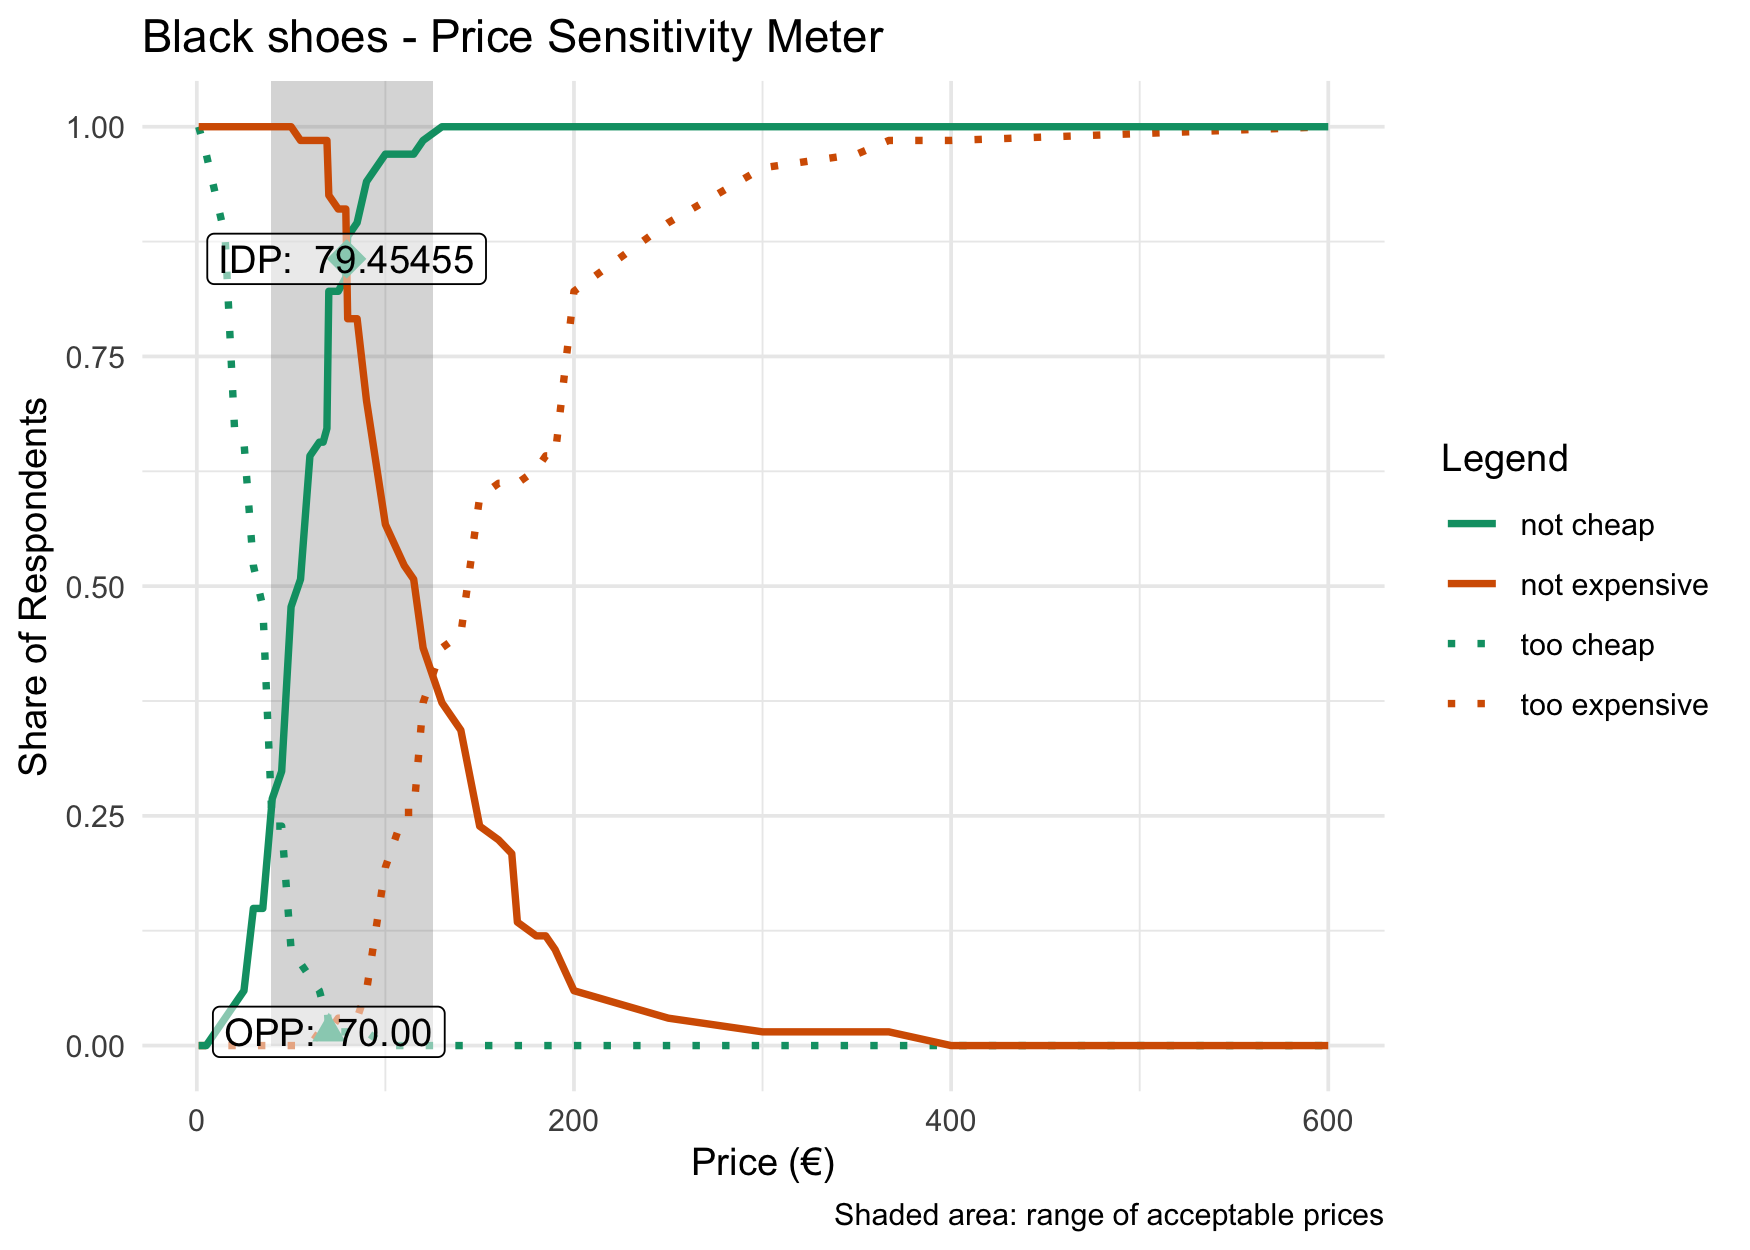

In [ ]:
options(repr.plot.height = 5,repr.plot.res = 250)

psm_plot(black_PSM) +
  labs(
    x = "Price (€)",
    y = "Share of Respondents",
    title = "Black shoes - Price Sensitivity Meter",
    caption = "Shaded area: range of acceptable prices") + 
  theme_minimal()

In this chart, the shaded area represents the range of prices respondents perceive as acceptable, which in our case is between 39.58 and 125. Within this range, the two key Price Sensitivity Meter reference points are the Optimal Price Point (OPP) = 70 and the Indifference Price Point (IDP) = 79.45, so a price around 70-80 sits in the "central zone" of price sensitivity and tends to align well with what the sample considers reasonable.
This analysis is based on 67 respondents out of 90 total, because 23 cases (26%) were excluded due to non-transitive price preferences. 

### White shoes

In [ ]:
white_PSM <- psm_analysis(toocheap = 'white_Too.Cheap', cheap = 'white_Bargain', expensive = 'white_Pricey', tooexpensive = 'white_Too.Expensive',
             data = pricing_data)

summary(white_PSM)

Van Westendorp Price Sensitivity Meter Analysis

Accepted Price Range: 40 - 128.33 
Indifference Price Point: 79.46154 
Optimal Price Point: 65 

---
68 cases with individual price preferences were analyzed (unweighted data).
Total data set consists of 90 cases. Analysis was limited to cases with transitive price preferences.
(Removed: n = 22 / 24% of data)

In [ ]:
# white_PSM$data_vanwestendorp

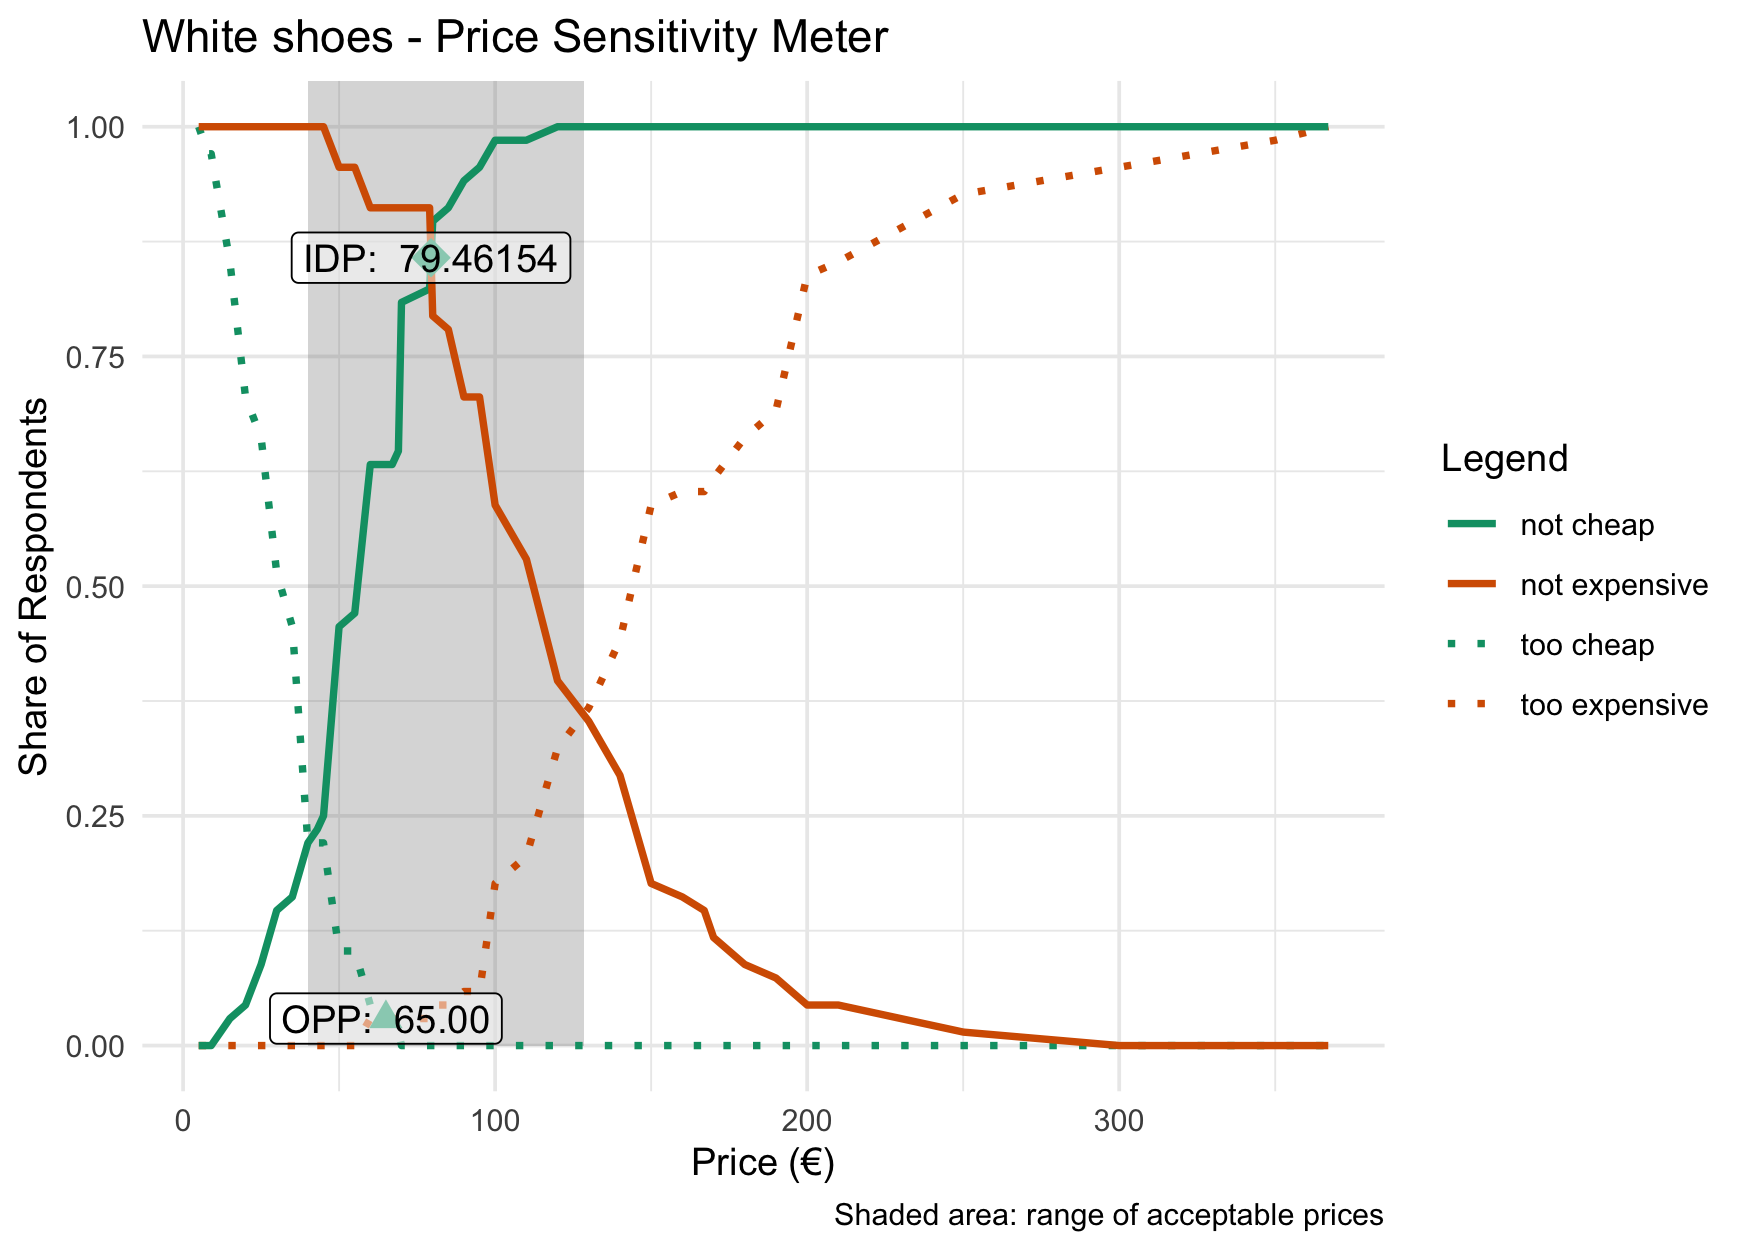

In [ ]:
options(repr.plot.height = 5,repr.plot.res = 250)

psm_plot(white_PSM) +
  labs(
    x = "Price (€)",
    y = "Share of Respondents",
    title = "White shoes - Price Sensitivity Meter",
    caption = "Shaded area: range of acceptable prices") + 
  theme_minimal()

For the white shoes chart, the acceptable range is very similar, at roughly 40–128.33.
The main difference is that the OPP drops to 65, while the IDP remains almost unchanged (≈ 79.46): this suggests that, even if the “reference” price is basically the same, the white version may start feeling “too expensive” a bit earlier, pushing the psychological optimum slightly downward.
Here, 68 respondents were analyzed, with 22 cases (24%) removed for non-transitive preferences.

### Comparison between PSM on white and black shoes
Overall, the two PSM results are highly consistent: the IDP is essentially identical (≈79.45 for black vs ≈79.46 for white), meaning the perceived “normal/fair” price is the same for both color variants.
The biggest difference is the OPP: 70 for black versus 65 for white (about 5 price units lower for white).
The acceptable price ranges are also almost the same (black 39.58–125, white 40–128.33), so the data supports a small gap rather than a major repositioning.

